<a href="https://colab.research.google.com/github/stepan-fukalov/ml/blob/master/predict_car_color_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Car Color Predictor

In [ ]:
import os
import gdown
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import shutil
from pathlib import Path
from PIL import Image
from random import randrange, sample
from distutils.dir_util import copy_tree

try:
  from icecream import ic
except:
  !pip install -q icecream
  from icecream import ic

In [ ]:
def default_device():
  '''Indicate availability of GPU, otherwise return CPU'''
  if torch.cuda.is_available():
    return 'cuda'
  else:
    return 'cpu'

def to_device(tensor, device):
  '''Move tensor to chosen device'''
  if isinstance(tensor, (list, tuple)):
    return [to_device(x, device) for x in tensor]
  return tensor.to(device, non_blocking=True)

In [ ]:
device = default_device()
device

'cuda'

## Data exploration

### Download and Import data

In [ ]:
url_dataset = "https://drive.google.com/file/d/1N656B2i0xR-oD-C1MXPvk_KxFqNinl4f/view?usp=share_link"
gdown.download(url=url_dataset,
               quiet=True,
               fuzzy=True)

url_masked_dataset = "https://drive.google.com/file/d/1UNWPYVZZPWRFZANYAp-9lT8fpSOY6UOJ/view?usp=sharing"
gdown.download(url=url_masked_dataset,
               quiet=True,
               fuzzy=True)

url_model = "https://drive.google.com/file/d/1hUuXRzMVzZ64at4V6Ro8v4mHDszgmDnz/view?usp=share_link"
gdown.download(url=url_model,
               quiet=True,
               fuzzy=True)

url_man_and_car_image = "https://drive.google.com/file/d/1js_pP6CsrLJCefxs08hYIW60J96AMQlk/view?usp=sharing"
gdown.download(url=url_man_and_car_image,
               quiet=True,
               fuzzy=True)

with zipfile.ZipFile("car_dataset.zip") as zip_ref:
  zip_ref.extractall("car_dataset")

with zipfile.ZipFile("new_car_dataset.zip") as zip_ref:
  zip_ref.extractall("new_car_dataset")

In [ ]:
train_dir = Path("car_dataset/train")
test_dir = Path("car_dataset/test")
colors = ['black', 'yellow', 'orange', 'purple', 'grey', 'white', 'brown', 'pink', 'red', 'green', 'blue']

In [ ]:
 # Parsing image file names grouped by color
train_names = {}
test_names = {}
for color in colors:
  train_color_dir = train_dir / color
  test_color_dir = test_dir / color
  train_names[color] = next(iter(os.walk(train_color_dir)))[2]
  test_names[color] = next(iter(os.walk(test_color_dir)))[2]

Both train and test sets consist classes with equal number of images.

Text(0.5, 1.0, 'Test')

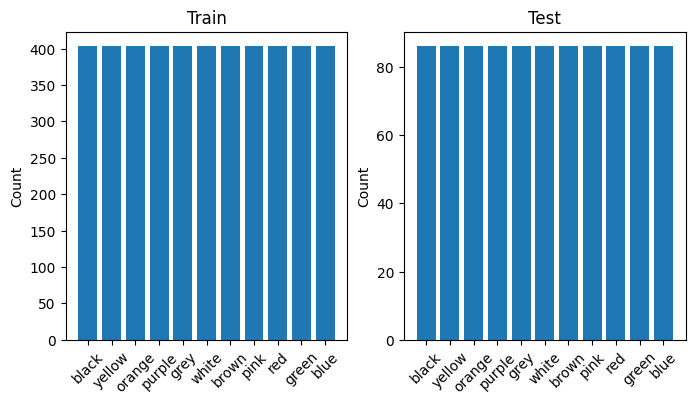

In [ ]:
plt.figure(figsize=(8, 4))

train_df = pd.DataFrame(train_names)
plt.subplot(1, 2, 1)
plt.bar(train_df.columns, train_df.count().values)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Train")

test_df = pd.DataFrame(test_names)
plt.subplot(1, 2, 2)
plt.bar(test_df.columns, test_df.count().values)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Test")

Verify that images correctly attached to classes and dataset doesn't contain wrong pairs.

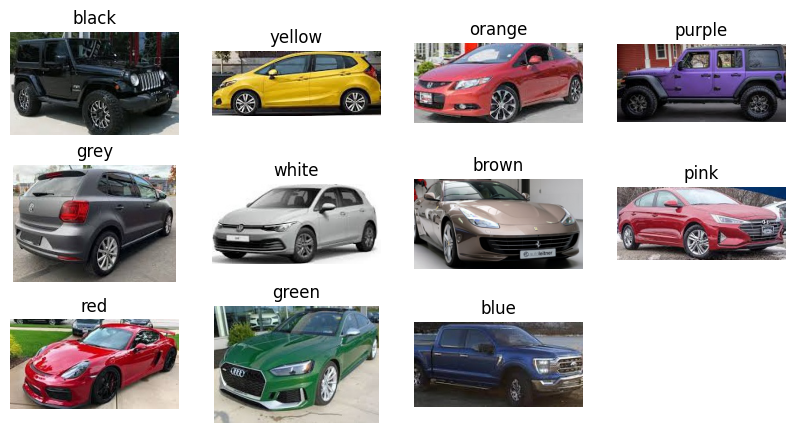

In [ ]:
plt.figure(figsize=(10, 7))
for i, color in enumerate(colors, 1):
  idx = randrange(0, len(train_names[color]))
  img_path = train_dir / color / train_names[color][idx]
  img = Image.open(img_path)
  plt.subplot(4, 4, i)
  plt.title(color)
  plt.axis("off")
  plt.imshow(img)

## Create masking function

In [ ]:
try:
  import pixellib
except:
  !pip install -q pixellib
  import pixellib

from pixellib.torchbackend.instance import instanceSegmentation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.3/430.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

Create temporary folder and files for testing segmentation

In [ ]:
temp = Path("temp")
temp.mkdir(parents=True, exist_ok=True)

image_path = Path("carAndMan.png")
temp_original = temp/"original_image.jpg"
shutil.copy(image_path, temp_original)

temp_masked = temp/"masked.jpg"
temp_segmented = temp/"segmented_image.jpg"

In [ ]:
DETECTION_SPEED = "fast" # [None, "fast", "rapid"]
# Unfortunately None Detection speed works bad, so I switched to fast  
ins = instanceSegmentation()
ins.load_model("pointrend_resnet50.pkl", detection_speed=DETECTION_SPEED)

INF = float("inf")

def update_box(final_box, box):
  final_box[0] = min(final_box[0], box[0])
  final_box[1] = min(final_box[1], box[1])
  final_box[2] = max(final_box[2], box[2])
  final_box[3] = max(final_box[3], box[3])

def update_mask(final_mask, mask):
  final_mask |= mask

def apply_mask(img, mask):
  img = img.transpose(2, 0, 1)
  for color_matrix in img:
    color_matrix *= mask
  img = img.transpose(1, 2, 0)
  return img

def process_img(image_path: str,
                output_path: str):
  img = Image.open(image_path)
  # Segmentation
  res = ins.segmentImage(image_path,
                  show_bboxes=True,
                  output_image_name=str(temp_segmented))
  # Merging masks (in case several detected)
  boxes = res[0]['boxes']
  masks = res[0]['masks'].transpose(2, 0, 1)
  class_names = res[0]['class_names']
  # ic(boxes)
  # ic(masks)
  # ic(class_names)

  final_mask = np.full(np.array(img).shape[:2], False)
  final_box = [INF, INF, -INF, -INF]

  car_detected = False
  for class_name, mask, box in zip(class_names, masks, boxes):
    if class_name not in ['car', 'bus', 'truck']: continue
    car_detected = True
    update_box(final_box, box)
    update_mask(final_mask, mask)
  # ic(car_detected)
  
  # ic(final_box)
  img = np.array(img)
  if car_detected: img = apply_mask(img, final_mask)
  img = Image.fromarray(img)
  img = img.convert('RGB')
  if car_detected: img = img.crop(final_box)
  img.save(output_path)

process_img(str(temp_original), str(temp_masked))

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


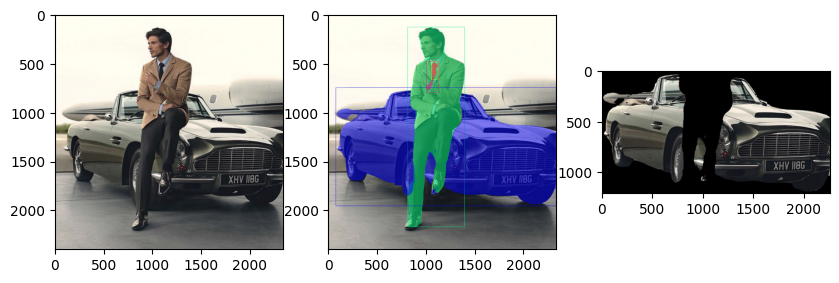

In [ ]:
from PIL import Image
img1 = Image.open(temp_original)
img2 = Image.open(temp_segmented)
img3 = Image.open(temp_masked)
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(img3)

## Create new dataset for images with masks

In [ ]:
# car_dataset_path = Path("car_dataset")
# car_dataset2_path = Path("car_dataset2")

# car_dataset2_path.mkdir(parents=True,
#                         exist_ok=True)

# copy_tree(str(car_dataset_path), str(car_dataset2_path))

In [ ]:
# for train_type in ["train", "test"]:
#   for color in colors:
#     input_folder = car_dataset_path / train_type / color;
#     output_folder = car_dataset2_path / train_type / color;
#     filenames = next(iter(os.walk(str(input_folder))))[2]
#     desc = str(input_folder)
#     for filename in tqdm(filenames, desc=desc):
#       input_path = input_folder / filename
#       output_path = output_folder / filename
#       process_img(str(input_path), str(output_path))

Creating zip archive of a new dataset

In [ ]:
# shutil.make_archive("car_dataset2", "zip", "car_dataset2")

Then I saved this dataset on Google Disk

## Let's show some masked images

In [ ]:
train_masked_dir = Path("new_car_dataset/train")
test_masked_dir = Path("new_car_dataset/test")
colors = ['black', 'yellow', 'orange', 'purple', 'grey', 'white', 'brown', 'pink', 'red', 'green', 'blue']

In [ ]:
 # Parsing image file names grouped by color
train_names = {}
test_names = {}
for color in colors:
  train_color_dir = train_masked_dir / color
  test_color_dir = test_masked_dir / color
  train_names[color] = next(iter(os.walk(train_color_dir)))[2]
  test_names[color] = next(iter(os.walk(test_color_dir)))[2]

Verify that images correctly attached to classes and dataset doesn't contain wrong pairs.

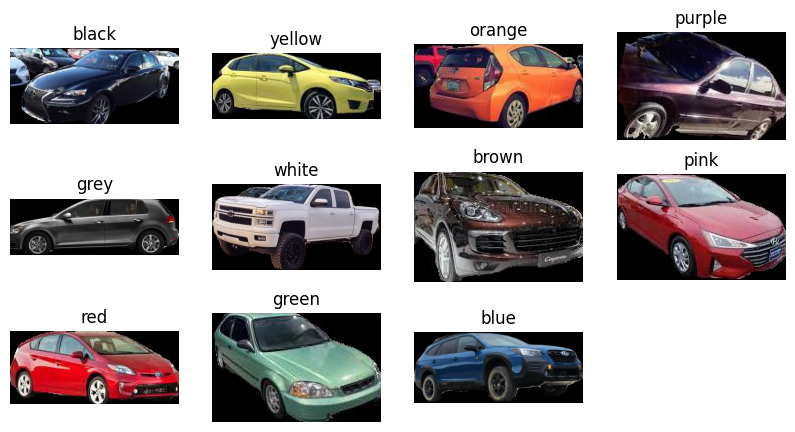

In [ ]:
plt.figure(figsize=(10, 7))
for i, color in enumerate(colors, 1):
  idx = randrange(0, len(train_names[color]))
  img_path = train_masked_dir / color / train_names[color][idx]
  img = Image.open(img_path)
  plt.subplot(4, 4, i)
  plt.title(color)
  plt.axis("off")
  plt.imshow(img)

## Datasets and Dataloaders

In [ ]:
BATCH_SIZE = 26

transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor(),
])

transform_normalized = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_labels = ["Dataset", "Dataset + Normalize", "Masked dataset", "Masked dataset + Normalize"]
trainsets = [
    ImageFolder(root=train_dir,
                transform=transform),
    ImageFolder(root=train_dir,
                transform=transform_normalized),
    ImageFolder(root=train_masked_dir,
                transform=transform),
    ImageFolder(root=train_masked_dir,
                transform=transform_normalized),
]

testsets = [
    ImageFolder(root=test_dir,
                transform=transform),
    ImageFolder(root=test_dir,
                transform=transform_normalized),
    ImageFolder(root=test_masked_dir,
                transform=transform),
    ImageFolder(root=test_masked_dir,
                transform=transform_normalized),
]

trainloaders = [
    DataLoader(trainsets[0],
                batch_size=BATCH_SIZE,
                shuffle=True),
    DataLoader(trainsets[1],
                batch_size=BATCH_SIZE,
                shuffle=True),
    DataLoader(trainsets[2],
                batch_size=BATCH_SIZE,
                shuffle=True),
    DataLoader(trainsets[3],
                batch_size=BATCH_SIZE,
                shuffle=True),                                    
]

testloaders = [
    DataLoader(testsets[0],
                batch_size=BATCH_SIZE,
                shuffle=False),
    DataLoader(testsets[1],
                batch_size=BATCH_SIZE,
                shuffle=False),
    DataLoader(testsets[2],
                batch_size=BATCH_SIZE,
                shuffle=False),
    DataLoader(testsets[3],
                batch_size=BATCH_SIZE,
                shuffle=False),                                    
]

classes = colors

In [ ]:
class DeviceDataloader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield batch of data after moving the data to a device'''
    for batch in self.dl:
      yield to_device(batch, device)

  def __len__(self):
    '''Return number of batches'''
    return len(self.dl)

In [ ]:
trainloaders = [DeviceDataloader(trainloader, device) for trainloader in trainloaders]
testloaders = [DeviceDataloader(testloader, device) for testloader in testloaders]

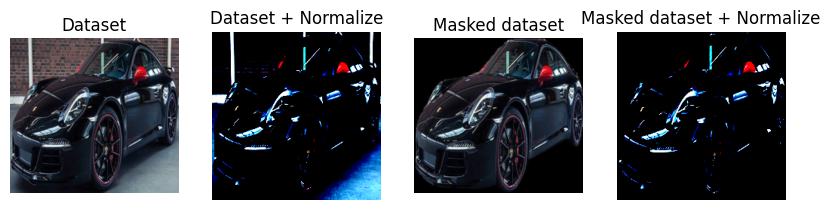

In [ ]:
fig = plt.figure(figsize=(10, 7))

for i in range(4):
  random_batch = next(iter(testloaders[i]))
  image = random_batch[0][0]
  label = testsets[i].classes[random_batch[1][0].item()]
  plt.subplot(1, 4, i+1)
  plt.imshow(image.permute(1, 2, 0).cpu())
  plt.title(dataset_labels[i])
  plt.axis('off')

## Creating Base and Helper Functions

### Evaluation Metric and Loss Function

In [ ]:
def accuracy(output, label):
  preds = torch.argmax(output, dim=1)
  accuracy_percent = (torch.sum(preds == label) / len(preds)).item()
  return accuracy_percent

In [ ]:
def evaluate(model, valid_dl):
  output = [model.validation_step(batch) for batch in valid_dl]
  epoch_loss = model.validation_epoch_end(output)
  return epoch_loss

In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

### Model Base

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
  def training_step(self, batch):
    image, label = batch
    
    out = self(image) # prediction generated
    loss = F.cross_entropy(out, label)
    return loss

  def validation_step(self, batch):
    image, label = batch
    out = self(image)
    loss = F.cross_entropy(out, label).item()
    acc = accuracy(out, label)
    return {'val_loss': loss, 'val_acc':acc}

  def validation_epoch_end(self, output):
    '''at the end of epoch, return average score (accuracy and cross entropy loss)'''
    batch_loss = np.array([x['val_loss'] for x in output])
    epoch_loss = batch_loss.mean().item()

    batch_accs = np.array([x['val_acc'] for x in output])
    epoch_acc = batch_accs.mean().item()
    return {'val_loss': epoch_loss, 'val_acc': epoch_acc}

  def epoch_end(self, epoch, result):
    '''Print out the score (accuracy and cross entropy loss) at the end of the epoch'''
    print("Epoch [{}], train_loss: {:}, val_loss: {:}, val_acc: {:}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def fit(epochs, model, trainloader, testloader, loss, scheduler,
        optimizer=torch.optim.SGD, weight_decay=0):
  torch.cuda.empty_cache()
  history = []
  
  for epoch in range(epochs):
    train_losses = []

    model.train()

    for batch in tqdm(trainloader):
      loss = model.training_step(batch)

      train_losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    model.eval()

    result = evaluate(model, testloader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    
    model.epoch_end(epoch, result)
    history.append(result)

    model.train()
    scheduler.step(result['val_acc'])
  return history

## Model

### Resnet 50

In [ ]:
class Resnet50(MultilabelImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = models.resnet50()
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, len(colors))

  def forward(self, xb):
    return self.network(xb)

model = to_device(Resnet50(), device)

In [ ]:
%%time
whole_history = []

for label, trainloader, testloader in zip(dataset_labels, trainloaders, testloaders):
  epochs = 10
  lr = 0.01
  optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=0.9)
  sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='max',
                                                   patience=3,
                                                   threshold=0.9)
  loss_fn = nn.CrossEntropyLoss()
  
  print(f"Training {label} for {epochs} epochs.")
  history = fit(epochs=epochs,
              model=model,
              trainloader=trainloader,
              testloader=testloader,
              loss=loss_fn,
              scheduler=sched,
              optimizer=optimizer)
  whole_history.append(history)

Training Dataset for 10 epochs.


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.644914150238037, val_loss: 1.3208168157049127, val_acc: 0.5137214308252206


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.2281403541564941, val_loss: 1.6468265336510297, val_acc: 0.6927235207042178


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8807676434516907, val_loss: 0.5387175348964898, val_acc: 0.8220374568088634


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6873387098312378, val_loss: 0.7156622663543031, val_acc: 0.8189189474324923


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5854568481445312, val_loss: 0.5381123243352851, val_acc: 0.8731809016820546


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.4534715712070465, val_loss: 0.3729905534434963, val_acc: 0.8943867345114012


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.41894179582595825, val_loss: 0.36586791005086255, val_acc: 0.8848233142414609


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3984343409538269, val_loss: 0.3592619719738896, val_acc: 0.8958420270198101


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.37909090518951416, val_loss: 0.38741627637598963, val_acc: 0.8979210338077029


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.34876447916030884, val_loss: 0.3500738026624596, val_acc: 0.8985447319778236
Training Dataset + Normalize for 10 epochs.


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.5605089664459229, val_loss: 0.7295304009741223, val_acc: 0.822869052758088


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.49668794870376587, val_loss: 0.4534648264682776, val_acc: 0.8372141734973805


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.4855475127696991, val_loss: 0.51082345239214, val_acc: 0.8812890085014137


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.45745858550071716, val_loss: 0.3933387005047218, val_acc: 0.889605019543622


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.41663891077041626, val_loss: 0.49063125927303286, val_acc: 0.8819127147262161


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.26146525144577026, val_loss: 0.3684067354109642, val_acc: 0.9120582406585281


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2309003323316574, val_loss: 0.2872068290472836, val_acc: 0.9141372458354847


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.21793805062770844, val_loss: 0.45193948969244957, val_acc: 0.9062370367952295


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.21312402188777924, val_loss: 0.4258692974375712, val_acc: 0.9120582422694644


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.18945559859275818, val_loss: 0.47761784681446245, val_acc: 0.9151767476184948
Training Masked dataset for 10 epochs.


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.48732826113700867, val_loss: 0.35600847275172537, val_acc: 0.8887734139287794


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.4382300078868866, val_loss: 0.3571979820325568, val_acc: 0.8850312168533737


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.39852651953697205, val_loss: 0.31246426636101426, val_acc: 0.9047817378430754


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.36430132389068604, val_loss: 0.3730805921997573, val_acc: 0.8802495051074672


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3365556597709656, val_loss: 0.4182192199939006, val_acc: 0.8896050243764311


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.21150848269462585, val_loss: 0.2827276078531066, val_acc: 0.9093555357005145


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.17728076875209808, val_loss: 0.2658085787316432, val_acc: 0.9187110453038603


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.15254555642604828, val_loss: 0.2655463637532415, val_acc: 0.9124740410495449


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.14487548172473907, val_loss: 0.28690908715833685, val_acc: 0.9166320449597126


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.13478058576583862, val_loss: 0.2777742082504807, val_acc: 0.910395039094461
Training Masked dataset + Normalize for 10 epochs.


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.3075793981552124, val_loss: 0.5236859837597286, val_acc: 0.8636174910777324


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3131493031978607, val_loss: 0.402554547967943, val_acc: 0.8765073128648706


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2803879678249359, val_loss: 0.3339648275963358, val_acc: 0.8991684253151352


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.22502100467681885, val_loss: 0.3699197509904971, val_acc: 0.8887734155397158


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.21007470786571503, val_loss: 0.4607910280543807, val_acc: 0.8792100081572661


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.11878727376461029, val_loss: 0.27387424623845397, val_acc: 0.9176715483536592


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.06485869735479355, val_loss: 0.2749658947105746, val_acc: 0.9207900520917531


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.05749960616230965, val_loss: 0.2595272366762967, val_acc: 0.9228690556577734


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.05744956433773041, val_loss: 0.2592947863143038, val_acc: 0.9249480543909846


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.04238312318921089, val_loss: 0.27202620520885734, val_acc: 0.9239085542189108
CPU times: user 35min 19s, sys: 18.4 s, total: 35min 38s
Wall time: 36min 10s


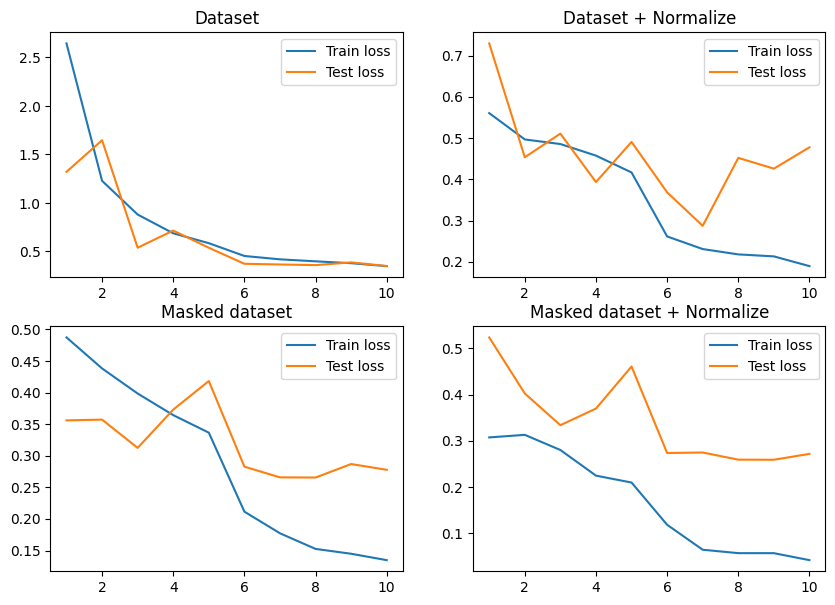

In [ ]:
fig = plt.figure(figsize=(10, 7))

def plot_history(label, train_loss, test_loss, index):
  ax = plt.subplot(2, 2, index)
  ax.set_title(label)
  ax.plot(range(1, len(train_loss)+1), train_loss, label="Train loss")
  ax.plot(range(1, len(test_loss)+1), test_loss, label="Test loss")
  ax.legend()

for i in range(4):
  train_loss = [x['train_loss'] for x in whole_history[i]]
  test_loss = [x['val_loss'] for x in whole_history[i]]
  plot_history(dataset_labels[i], train_loss, test_loss, i+1)

Text(0.5, 1.0, 'Test Accuracy')

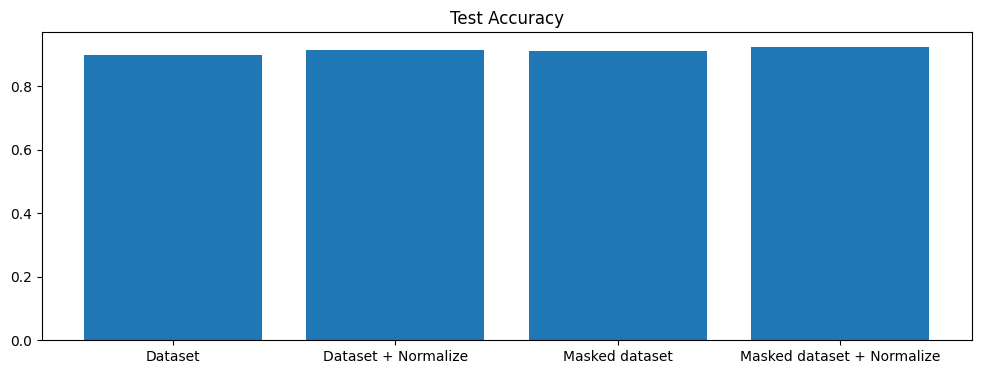

In [ ]:
plt.figure(figsize=(12, 4))
x = dataset_labels
y = [h[-1]['val_acc'] for h in whole_history]
plt.bar(x, y)
plt.title("Test Accuracy")